# Challenge-1 : Final Spark Project

#### Team: Group O2-6

MARIA MUÑOZ GALLEGO <mariamgallego@student.ie.edu>

Karim Al-Masri <karim.almasri@student.ie.edu>

FAISAL EL-SHAMI <F.elshami@student.ie.edu>

JAVIER GRANDA GARCÍA <javiergranda@student.ie.edu>

MAXIMILIAN HUANG <huangyangjia@student.ie.edu>

AHSAN AFTAB <ahsan.aftab@student.ie.edu>


##### Submitted to: 

PROFESSOR ASIER ABREU ARAMBURU


###### Date: 21-03-18

# About our Spark Cluster Setup

Our cluster is built on 2 servers YARN + Hadoop setup and runs Spark over Hadoop and Yarn for maximizing the processing effect. Our cluster is centrally controlled by a self-developed and configured framework like Marathon (a framework that integrates with Mesos to operate on cloud). 
We will not run spark on Mesos in this project, though depending on use case it can be highly productive.

### Cluster Resources and Utilization

Since we have two machines in our cluster, we will use Hadoop for HDFS, and then run spark over Yarn to improve our processing efficiency. Since cluster is very small and composed just of only two nodes (4 RAM GB each which is more challenging, since it requires a lot of optimization of resources), the processing time for certain steps below might be more than a minute. However we have provided with time in seconds with each step to help you analyze the time required by each step. In production, we expect this time to be in seconds.

Our cutsomized developed framework, which actually works like Marathon, Cloudera Manager helps us to analyze the efficiency of our resources while different queries are running on Spark. Follows the sanpshot and link to dashboard of runnng framework controlling different cluster resources.


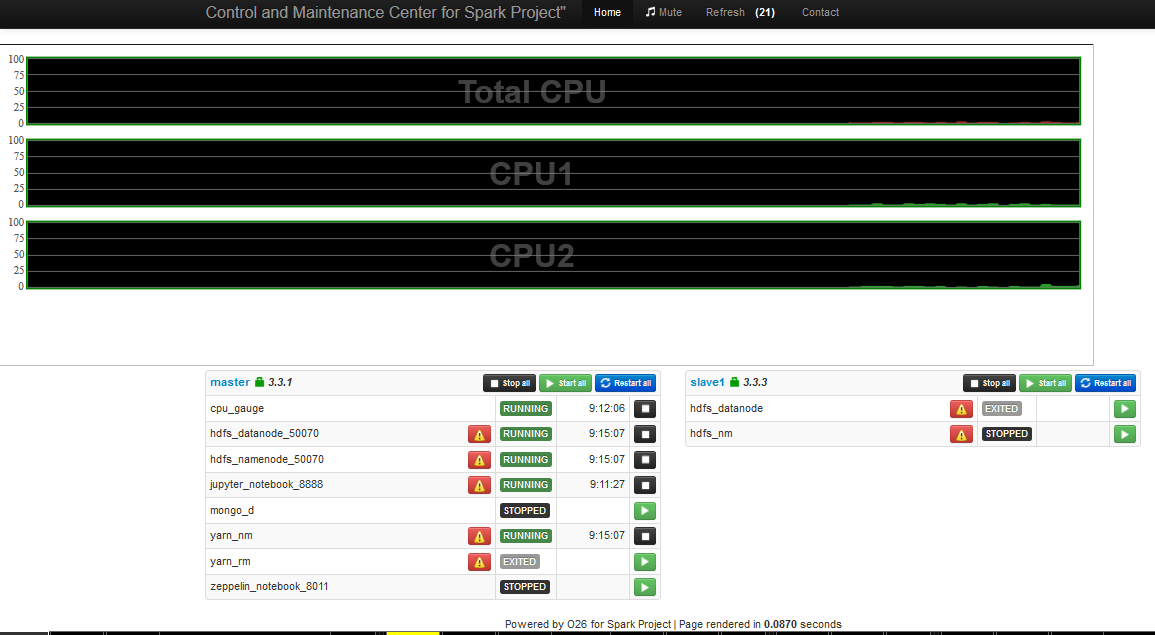

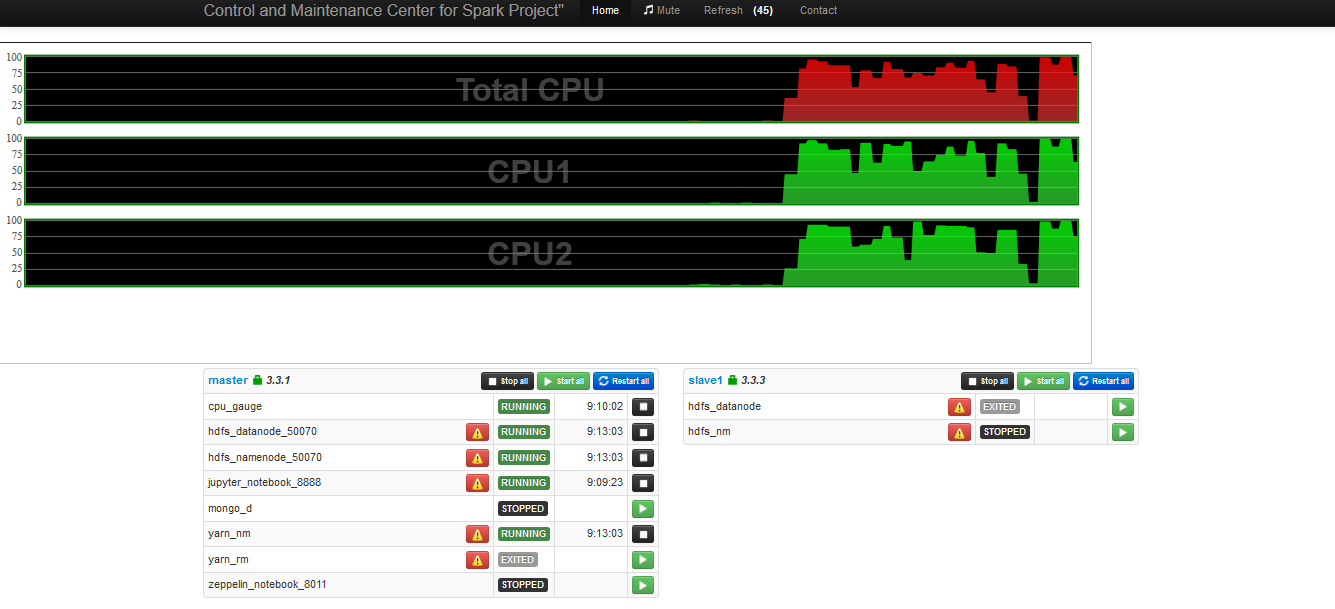

Real-Time Dashboard link: http://172.104.51.113:8082/

Please Run this Cell in order to refresh the view.

In [11]:
from IPython.display import IFrame
IFrame('http://172.104.51.113:8082/', width=1042, height=700)


### Spark+HDFS+YARN Web UIs

Real-Time Dashboard link: http://172.104.51.113:4040/

The following dashboard is accessible only when Spark job is running

Please Run this Cell in order to refresh the view.

In [13]:
from IPython.display import IFrame
IFrame('http://172.104.51.113:8111/proxy/application_1521433163126_0004/', width=1042, height=700)

This section shows Spark Web UI that can be used to analyse the performance of Spark jobs running over Yarn.
We highly recommend to use it along with Spark History Server, Hadoop History Server and Yarn Web UI to better analyse the performance of running application on the Hadoop Cluster.

Real-Time Dashboard link: http://172.104.51.113:8111/cluster

Please Run this Cell in order to refresh the view.

In [14]:
from IPython.display import IFrame
IFrame('http://172.104.51.113:8111/cluster', width=1042, height=700)

Real-Time Dashboard link: http://172.104.51.113:50070

Follows the link to our HDFS:

Please Run this Cell in order to refresh the view.

In [15]:
from IPython.display import IFrame
IFrame('http://172.104.51.113:50070', width=1042, height=700)

# 1- Loading of Data

### a) Load libraries for spark and python

Python libraries and Python3.6 along with PIP3.6 and devtools have been deployed on all slave nodes along with following libraries:

1-pyspark
2-findspark
3-pandas
4-numpy
5-matplotlib
6-scikit-learn
7-bookeh
8-seaborn

Note: If Python isn't installed with libraries on the slave nodes, the setup might operate in local mode but will fail to operate in cluster mode. In order to get the most out of Pyspark, it is recommended to use the cluster setup.

In [8]:
#python version check for notebook
import platform
print(platform.python_version())
#Confirm Python version to be 3.6.4

3.6.4


In [1]:
#Some prework
#Some of our favorite libraries go here
import math
import itertools
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import OrderedDict
%matplotlib inline

#Check and confirm spark home path
import os
print(os.environ['SPARK_HOME'])  #runs on my private cluster. spark installed at /opt/spark
# You need this to run Spark in the cluster

#findspark and verify the path
import findspark
findspark.init()


#Add further libraries of pyspark
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import HiveContext, SparkSession
from IPython.display import display  #we would use display for better output
from pyspark.sql import SQLContext, Row
from pyspark.context import SparkContext
from pyspark.sql.types import *
from pyspark.sql.functions import udf, split, col
import pyspark.sql.functions as sql
from pyspark.sql.functions import col
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import StringIndexer
from pyspark import keyword_only
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import StringIndexer
from pyspark import keyword_only
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer

from pyspark.sql.functions import col, create_map, lit
from itertools import chain

#More libraries
#SQL
from pyspark.sql import HiveContext, SparkSession
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.functions import udf, split, col
import pyspark.sql.functions as sql
from pyspark.sql.functions import lit

#ML Tools
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.linalg import DenseVector
from pyspark.ml.linalg import VectorUDT

#DataFrame Tools
import numpy as np
import pandas as pd

#Import Regular Expression
import re

#Done loading libraries


/opt/spark


### b) Data Storage

The data was stored on local disk at :      /app/jupyter_WD/challenge_1

The same data was also stored on HDFS at:   hdfs://user/hduser/data/challenge_1/


Each disk is equipped with 50 G and each partition of HDFS on each slave is equipped with 30G that is sufficient for the data requirements of this project.


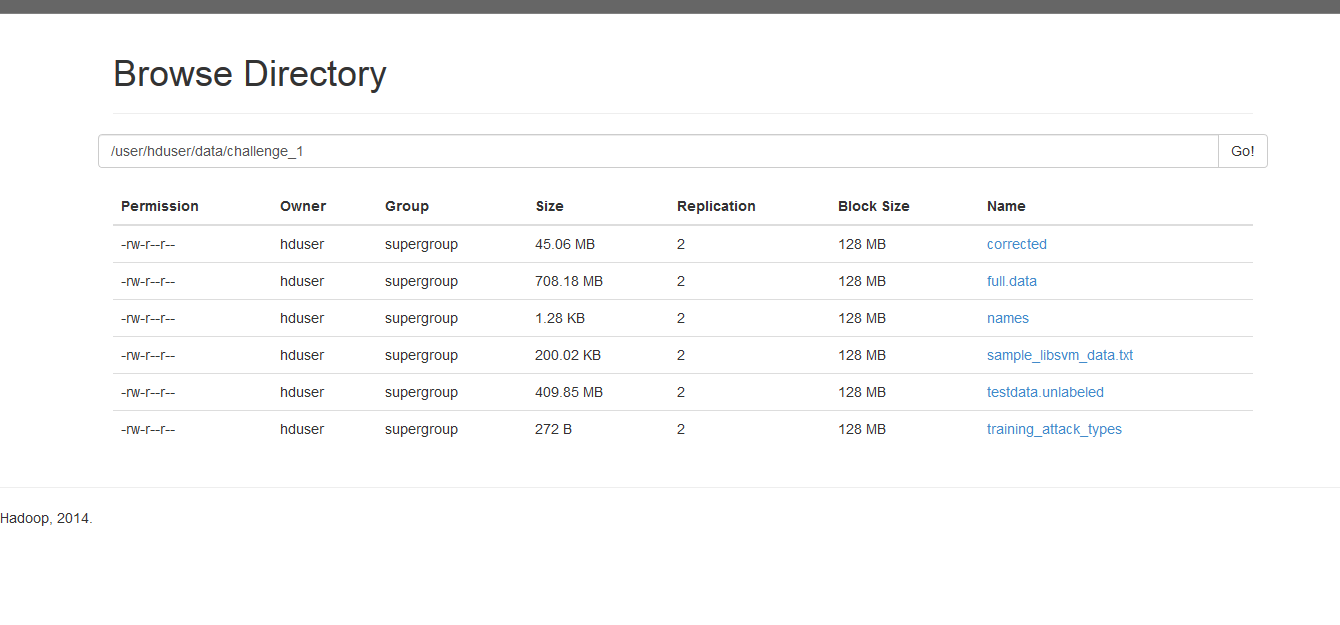

In [2]:
#Where our dataset is stored on HDFS
dataset_path="/data/challenge_1/"
#show the path of dataset
print(dataset_path)

/data/challenge_1/


### c)Initiate Spart Session and create Spark Context on YARN

In [3]:
spark = SparkSession.builder.master("yarn-client").appName("Spark-Final-Project").enableHiveSupport().getOrCreate()
sc = SparkContext.getOrCreate() #get existing SparkContext
#save it as sc
#Hive metastore support enabled.

# 2- Data Inspection

In [28]:
#Load the column names into desired arrays for train dataset
col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])

#Load the column names into desired arrays for final prediction dataset
col_names_test = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"])

#prework for nominal binary and numeric variables.
nominal_inx = [1, 2, 3]
binary_inx = [6, 11, 13, 14, 20, 21]
numeric_inx = list(set(range(41)).difference(nominal_inx).difference(binary_inx))

#convert them from arrays to lists
nominal_cols = col_names[nominal_inx].tolist()
binary_cols = col_names[binary_inx].tolist()
numeric_cols = col_names[numeric_inx].tolist()

The following information is given in the file attack_types provided in 'challenge_1' directory.
We found out different attack types and then were able to see them from two dimensions

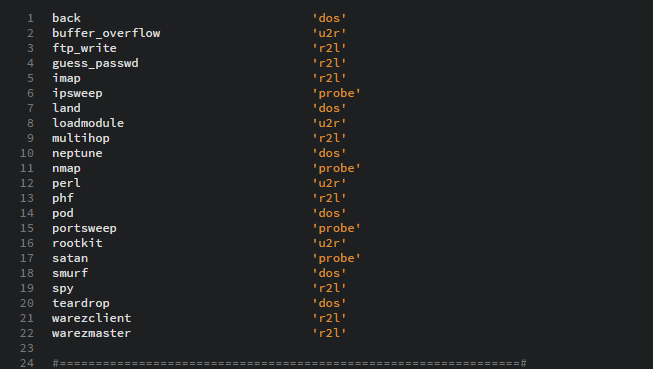

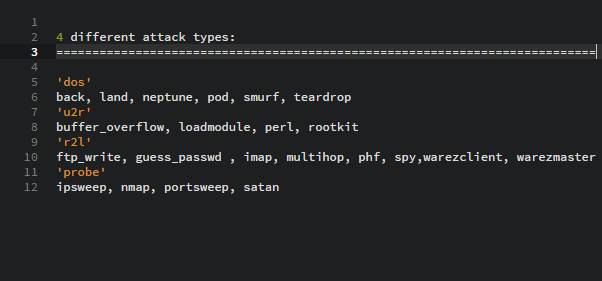


Having a general feel of data, loading it from hdfs and verifying if Spark over Yarn is working perfect for
our two node cluster.

Note : More detailed data inspection has been carried out in continuity with the next section.

# 3-Data Exploration

Loading the Training Dataset and Test dataset and measuring rows and time required to load the data.
Approximate time for this 3 step is more than a minute.
Addition of extra columns to the datset takes 2 more minutes.

Total time is around 200 sec.

In [29]:
# We will use following function to load dataset and append field names right on the top of dataframe
def load_dataset(path):
    dataset_rdd = sc.textFile(path, 8).map(lambda line: line.split(','))
    dataset_df = (dataset_rdd.toDF(col_names.tolist()).select(
                    col('duration').cast(DoubleType()),
                    col('protocol_type').cast(StringType()),
                    col('service').cast(StringType()),
                    col('flag').cast(StringType()),
                    col('src_bytes').cast(DoubleType()),
                    col('dst_bytes').cast(DoubleType()),
                    col('land').cast(DoubleType()),
                    col('wrong_fragment').cast(DoubleType()),
                    col('urgent').cast(DoubleType()),
                    col('hot').cast(DoubleType()),
                    col('num_failed_logins').cast(DoubleType()),
                    col('logged_in').cast(DoubleType()),
                    col('num_compromised').cast(DoubleType()),
                    col('root_shell').cast(DoubleType()),
                    col('su_attempted').cast(DoubleType()),
                    col('num_root').cast(DoubleType()),
                    col('num_file_creations').cast(DoubleType()),
                    col('num_shells').cast(DoubleType()),
                    col('num_access_files').cast(DoubleType()),
                    col('num_outbound_cmds').cast(DoubleType()),
                    col('is_host_login').cast(DoubleType()),
                    col('is_guest_login').cast(DoubleType()),
                    col('count').cast(DoubleType()),
                    col('srv_count').cast(DoubleType()),
                    col('serror_rate').cast(DoubleType()),
                    col('srv_serror_rate').cast(DoubleType()),
                    col('rerror_rate').cast(DoubleType()),
                    col('srv_rerror_rate').cast(DoubleType()),
                    col('same_srv_rate').cast(DoubleType()),
                    col('diff_srv_rate').cast(DoubleType()),
                    col('srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_count').cast(DoubleType()),
                    col('dst_host_srv_count').cast(DoubleType()),
                    col('dst_host_same_srv_rate').cast(DoubleType()),
                    col('dst_host_diff_srv_rate').cast(DoubleType()),
                    col('dst_host_same_src_port_rate').cast(DoubleType()),
                    col('dst_host_srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_serror_rate').cast(DoubleType()),
                    col('dst_host_srv_serror_rate').cast(DoubleType()),
                    col('dst_host_rerror_rate').cast(DoubleType()),
                    col('dst_host_srv_rerror_rate').cast(DoubleType()),
                    col('labels').cast(StringType())))

    return dataset_df

The following is a computation intensive step, takes around: 230 seconds

In [30]:
# Loading train data
t0 = time()   #we will use this to measure data load time
#load_dataset is the function defined above
train_df = load_dataset("hdfs://"+dataset_path+"full.data") #Using HDFS data for our YARN mode

# We will define a dictionary so we may segregate our attacks to the four main categories
attack_dict = {
    'normal.': 'normal',
    
    'back.': 'DoS',
    'land.': 'DoS',
    'neptune.': 'DoS',
    'pod.': 'DoS',
    'smurf.': 'DoS',
    'teardrop.': 'DoS',
    'mailbomb.': 'DoS',
    'apache2.': 'DoS',
    'processtable.': 'DoS',
    'udpstorm.': 'DoS',
    'ipsweep.': 'Probe',
    'nmap.': 'Probe',
    'portsweep.': 'Probe',
    'satan.': 'Probe',
    'mscan.': 'Probe',
    'saint.': 'Probe',
    'ftp_write.': 'R2L',
    'guess_passwd.': 'R2L',
    'imap.': 'R2L',
    'multihop.': 'R2L',
    'phf.': 'R2L',
    'spy.': 'R2L',
    'warezclient.': 'R2L',
    'warezmaster.': 'R2L',
    'sendmail.': 'R2L',
    'named.': 'R2L',
    'snmpgetattack.': 'R2L',
    'snmpguess.': 'R2L',
    'xlock.': 'R2L',
    'xsnoop.': 'R2L',
    'worm.': 'R2L',
    'buffer_overflow.': 'U2R',
    'loadmodule.': 'U2R',
    'perl.': 'U2R',
    'rootkit.': 'U2R',
    'httptunnel.': 'U2R',
    'ps.': 'U2R',    
    'sqlattack.': 'U2R',
    'xterm.': 'U2R'
}

#Add one more column with labels 'attack' and 'normal'
train_df = train_df.withColumn('labels2', sql.regexp_replace(col('labels'), '^(?!normal).*$', 'attack'))

mapping_expr = create_map([lit(x) for x in chain(*attack_dict.items())])
train_df = train_df.withColumn('labels5', mapping_expr.getItem(col('labels')))
train_df.head(20)

labels2_indexer = StringIndexer(inputCol="labels2", outputCol="labels2_index")
labels5_indexer = StringIndexer(inputCol="labels5", outputCol="labels5_index")
labels2 = ['normal', 'attack']
labels5 = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
labels_col = 'labels2_index'

# Next we will use string indexer from pyspark and learn the model
string_indexer_model2 = labels2_indexer.fit(train_df)
string_indexer_model5 = labels5_indexer.fit(train_df)

# transform the data using stringIndexer of pyspark
train_df = string_indexer_model2.transform(train_df).withColumn('id', sql.monotonically_increasing_id())
train_df = string_indexer_model5.transform(train_df).withColumn('id', sql.monotonically_increasing_id())


train_df = train_df.cache()
print(train_df.count())          #count the rows of our train_df, (number of rows in full.data)
print(time() - t0)               #prints the time in seconds it too to load the data


4898431
228.74919652938843


In [31]:
#Repeat the steps and procedure above for "corrected" dataset that is also our validation dataset.

#load_dataset is the function defined above
test_df = load_dataset("hdfs://"+dataset_path+"corrected") #Using HDFS data for our YARN mode

#Using same dictionary as above
test_df = test_df.withColumn('labels2', sql.regexp_replace(col('labels'), '^(?!normal).*$', 'attack'))


from pyspark.sql.functions import col, create_map, lit
from itertools import chain

mapping_expr = create_map([lit(x) for x in chain(*attack_dict.items())])

test_df = test_df.withColumn('labels5', mapping_expr.getItem(col('labels')))
test_df.head(20)

labels2_indexer = StringIndexer(inputCol="labels2", outputCol="labels2_index")
labels5_indexer = StringIndexer(inputCol="labels5", outputCol="labels5_index")
labels2 = ['normal', 'attack']
labels5 = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
labels_col = 'labels2_index'

# learn the model
string_indexer_model2 = labels2_indexer.fit(test_df)
string_indexer_model5 = labels5_indexer.fit(test_df)

# transform the data
test_df = string_indexer_model2.transform(test_df).withColumn('id', sql.monotonically_increasing_id())
test_df = string_indexer_model5.transform(test_df).withColumn('id', sql.monotonically_increasing_id())


test_df = test_df.cache()
print(test_df.count())          #count the rows of our test_df, (number of rows in full.data)
print(time() - t0)               #prints the time in seconds it too to load the data


311029
275.0888330936432


Lets analyse and inspect data from some dimensions:

Next we will analyse the distribution of various variables

In [32]:
# Labels columns
(train_df.groupby('labels2').count().show())
(train_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-------+
|labels2|  count|
+-------+-------+
| attack|3925650|
|normal.| 972781|
+-------+-------+

+-------+-------+
|labels5|  count|
+-------+-------+
|    DoS|3883370|
| normal| 972781|
|  Probe|  41102|
|    R2L|   1126|
|    U2R|     52|
+-------+-------+



In [33]:
(test_df.groupby('labels2').count().show())
(test_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+------+
|labels2| count|
+-------+------+
| attack|250436|
|normal.| 60593|
+-------+------+

+-------+------+
|labels5| count|
+-------+------+
|    DoS|229853|
| normal| 60593|
|    R2L| 16189|
|  Probe|  4166|
|    U2R|   228|
+-------+------+



In [34]:
# 'protocol_type' nominal column
(train_df.crosstab(nominal_cols[0], 'labels2').sort(sql.asc(nominal_cols[0] + '_labels2')).show())
(train_df.crosstab(nominal_cols[0], 'labels5').sort(sql.asc(nominal_cols[0] + '_labels5')).show())

+---------------------+-------+-------+
|protocol_type_labels2| attack|normal.|
+---------------------+-------+-------+
|                 icmp|2820782|  12763|
|                  tcp|1101928| 768670|
|                  udp|   2940| 191348|
+---------------------+-------+-------+

+---------------------+-------+-----+----+---+------+
|protocol_type_labels5|    DoS|Probe| R2L|U2R|normal|
+---------------------+-------+-----+----+---+------+
|                 icmp|2808150|12632|   0|  0| 12763|
|                  tcp|1074241|26512|1126| 49|768670|
|                  udp|    979| 1958|   0|  3|191348|
+---------------------+-------+-----+----+---+------+



In [35]:
# 'service' nominal column
print(train_df.select(nominal_cols[1]).distinct().count())
(train_df.crosstab(nominal_cols[1], 'labels2').sort(sql.asc(nominal_cols[1] + '_labels2')).show(n=70))
(train_df.crosstab(nominal_cols[1], 'labels5').sort(sql.asc(nominal_cols[1] + '_labels5')).show(n=70))

70
+---------------+-------+-------+
|service_labels2| attack|normal.|
+---------------+-------+-------+
|            IRC|      1|    520|
|            X11|      6|    129|
|         Z39_50|   1078|      0|
|            aol|      2|      0|
|           auth|   1054|   2328|
|            bgp|   1047|      0|
|        courier|   1021|      0|
|       csnet_ns|   1051|      0|
|            ctf|   1068|      0|
|        daytime|   1056|      0|
|        discard|   1059|      0|
|         domain|   1075|     38|
|       domain_u|      9|  57773|
|           echo|   1059|      0|
|          eco_i|  12570|   3768|
|          ecr_i|2808204|   3456|
|            efs|   1042|      0|
|           exec|   1045|      0|
|         finger|   1874|   5017|
|            ftp|   1393|   3821|
|       ftp_data|   2604|  38093|
|         gopher|   1077|      0|
|        harvest|      2|      0|
|      hostnames|   1050|      0|
|           http|   4045| 619046|
|      http_2784|      1|      0|
|       htt

In [36]:
# 'flag' nominal column
print(train_df.select(nominal_cols[2]).distinct().count())
(train_df.crosstab(nominal_cols[2], 'labels2').sort(sql.asc(nominal_cols[2] + '_labels2')).show())
(train_df.crosstab(nominal_cols[2], 'labels5').sort(sql.asc(nominal_cols[2] + '_labels5')).show())

11
+------------+-------+-------+
|flag_labels2| attack|normal.|
+------------+-------+-------+
|         OTH|     44|     13|
|         REJ| 215401|  53473|
|        RSTO|   4744|    600|
|      RSTOS0|    122|      0|
|        RSTR|   7760|    334|
|          S0| 869405|    424|
|          S1|      4|    528|
|          S2|      8|    153|
|          S3|      4|     46|
|          SF|2827120| 917208|
|          SH|   1038|      2|
+------------+-------+-------+

+------------+-------+-----+----+---+------+
|flag_labels5|    DoS|Probe| R2L|U2R|normal|
+------------+-------+-----+----+---+------+
|         OTH|      0|   44|   0|  0|    13|
|         REJ| 199970|15431|   0|  0| 53473|
|        RSTO|   4600|   97|  46|  1|   600|
|      RSTOS0|      0|  122|   0|  0|     0|
|        RSTR|     91| 7664|   5|  0|   334|
|          S0| 867467| 1937|   1|  0|   424|
|          S1|      2|    1|   1|  0|   528|
|          S2|      5|    2|   1|  0|   153|
|          S3|      0|    1|   3|  0

In [37]:
# Binary columns
(train_df.select(binary_cols).describe().toPandas().transpose())

,0,1,2,3,4
summary,count,mean,stddev,min,max
land,4898431,5.716116037972159E-6,0.00239083343855466,0.0,1.0
logged_in,4898431,0.14352901980246327,0.3506115590970786,0.0,1.0
root_shell,4898431,6.81850984529536E-5,0.00825714618764484,0.0,1.0
su_attempted,4898431,3.674646024410674E-5,0.008082431779339249,0.0,2.0
is_host_login,4898431,4.082940027122971E-7,6.389788097897229E-4,0.0,1.0
is_guest_login,4898431,8.351653825480036E-4,0.028887160671930617,0.0,1.0


In [38]:
# 'su_attempted' should be a binary feature, but has 3 values
(train_df.crosstab('su_attempted', 'labels2').show())

+--------------------+-------+-------+
|su_attempted_labels2| attack|normal.|
+--------------------+-------+-------+
|                 2.0|      0|     70|
|                 1.0|      1|     39|
|                 0.0|3925649| 972672|
+--------------------+-------+-------+



In [39]:
# '2.0' value is replaced to '0.0' for both train and test datasets
train_df = train_df.replace(2.0, 0.0, 'su_attempted')
test_df = test_df.replace(2.0, 0.0, 'su_attempted')

In [40]:
# Numeric columns
print(len(numeric_cols))
summary = (train_df.select(numeric_cols).describe().toPandas().transpose())
print(summary)

32
                                   0                      1  \
summary                        count                   mean   
duration                     4898431      48.34243046395876   
src_bytes                    4898431     1834.6211752293746   
dst_bytes                    4898431     1093.6228137132073   
wrong_fragment               4898431   6.487791703098401E-4   
urgent                       4898431   7.961733052889793E-6   
hot                          4898431   0.012437656057623349   
num_failed_logins            4898431   3.205107921291532E-5   
num_compromised              4898431   0.008088304193730605   
num_root                     4898431   0.012934958152926926   
num_file_creations           4898431  0.0011887479888968528   
num_shells                   4898431   7.430950849363806E-5   
num_access_files             4898431   0.001021143300783455   
num_outbound_cmds            4898431                    0.0   
count                        4898431     334.9734402

In [41]:
(train_df.crosstab('num_outbound_cmds', 'labels2').show())

+-------------------------+-------+-------+
|num_outbound_cmds_labels2| attack|normal.|
+-------------------------+-------+-------+
|                      0.0|3925650| 972781|
+-------------------------+-------+-------+



Since the value of this feature is always zero, it adds no information in training process and therefore can be removed.

In [42]:
train_df = train_df.drop('num_outbound_cmds')
test_df = test_df.drop('num_outbound_cmds')
numeric_cols.remove('num_outbound_cmds')

### Using one hot encoding for categorical variables

In [43]:
#We are performing one hot encoding here so we may apply PCA and classify our data based on labels 
#for better visualization.

#we will use this function for categorical variables
def ohe_vec(cat_dict, row):
    vec = np.zeros(len(cat_dict))
    vec[cat_dict[row]] = float(1.0)
    return vec.tolist()

#Will use this function for nominal variables.
def ohe(df, nominal_col):
    categories = (df.select(nominal_col)
                    .distinct()
                    .rdd.map(lambda row: row[0])
                    .collect())
    
    cat_dict = dict(zip(categories, range(len(categories))))
    
    udf_ohe_vec = udf(lambda row: ohe_vec(cat_dict, row), 
                      StructType([StructField(cat, DoubleType(), False) for cat in categories]))
    
    df = df.withColumn(nominal_col + '_ohe', udf_ohe_vec(col(nominal_col))).cache()
    
    nested_cols = [nominal_col + '_ohe.' + cat for cat in categories]
    ohe_cols = [nominal_col + '_' + cat for cat in categories]
        
    for new, old in zip(ohe_cols, nested_cols):
        df = df.withColumn(new, col(old))

    df = df.drop(nominal_col + '_ohe')
                   
    return df, ohe_cols




#### Note : 
The one hot encoding is a computation intensive step and can take a few minutes to complete.
Estimated time : 333 sec

In [44]:
#Performing one hot encoding, we get the results
t0 = time()
train_ohe_cols = []

train_df, train_ohe_col0 = ohe(train_df, nominal_cols[0])
train_ohe_cols += train_ohe_col0

train_df, train_ohe_col1 = ohe(train_df, nominal_cols[1])
train_ohe_cols += train_ohe_col1

train_df, train_ohe_col2 = ohe(train_df, nominal_cols[2])
train_ohe_cols += train_ohe_col2

binary_cols += train_ohe_cols

train_df = train_df.cache()
print(train_df.count())
print(time() - t0)  #gives the time in seconds for one hot encoding

4898431
283.68610405921936


In [45]:
#Repeating the one hot encoding for validation test data
t0 = time()
test_ohe_cols = []

test_df, test_ohe_col0_names = ohe(test_df, nominal_cols[0])
test_ohe_cols += test_ohe_col0_names

test_df, test_ohe_col1_names = ohe(test_df, nominal_cols[1])
test_ohe_cols += test_ohe_col1_names

test_df, test_ohe_col2_names = ohe(test_df, nominal_cols[2])
test_ohe_cols += test_ohe_col2_names

test_binary_cols = col_names[binary_inx].tolist() + test_ohe_cols

test_df = test_df.cache()
print(test_df.count())
print(time() - t0)   #gives the time in seconds for one hot encoding

311029
43.24640393257141


# 3- Data Pre-Processing, Feature Selection and Visualization

For feature selection purpose, out of available options, now we will use the parameter of attribute ratio.

In [28]:
def getAttributeRatio(df, numericCols, binaryCols, labelCol):
    ratio_dict = {}
    
    if numericCols:
        avg_dict = (df
                .select(list(map(lambda c: sql.avg(c).alias(c), numericCols)))
                .first()
                .asDict())

        ratio_dict.update(df
                .groupBy(labelCol)
                .avg(*numericCols)
                .select(list(map(lambda c: sql.max(col('avg(' + c + ')')/avg_dict[c]).alias(c), numericCols)))
                .fillna(0.0)
                .first()
                .asDict())
    
    if binaryCols:
        ratio_dict.update((df
                .groupBy(labelCol)
                .agg(*list(map(lambda c: (sql.sum(col(c))/(sql.count(col(c)) - sql.sum(col(c)))).alias(c), binaryCols)))
                .fillna(1000.0)
                .select(*list(map(lambda c: sql.max(col(c)).alias(c), binaryCols)))
                .first()
                .asDict()))
        
    return OrderedDict(sorted(ratio_dict.items(), key=lambda v: -v[1]))

def selectFeaturesByAR(ar_dict, min_ar):
    return [f for f in ar_dict.keys() if ar_dict[f] >= min_ar]

In [29]:
t0 = time()
ar_dict = getAttributeRatio(train_df, numeric_cols, binary_cols, 'labels5')

print(len(ar_dict))
print(time() - t0)
ar_dict

121
149.9432098865509


OrderedDict([('urgent', 2415.3999013806706),
             ('num_shells', 1811.549926035503),
             ('num_failed_logins', 1551.6972089918654),
             ('protocol_type_tcp', 1000.0),
             ('num_file_creations', 663.270555093198),
             ('hot', 594.1534025251617),
             ('num_compromised', 149.78893381353626),
             ('src_bytes', 148.24454131047065),
             ('dst_bytes', 66.1150655811894),
             ('num_root', 60.95586310676429),
             ('flag_SF', 51.0),
             ('dst_host_srv_diff_host_rate', 29.280842737990362),
             ('diff_srv_rate', 19.22784045660093),
             ('dst_host_diff_srv_rate', 19.203242777639392),
             ('num_access_files', 18.832586196290716),
             ('duration', 12.215344948643171),
             ('logged_in', 11.942528735632184),
             ('rerror_rate', 9.836771655148537),
             ('srv_rerror_rate', 9.803189497072854),
             ('dst_host_srv_rerror_rate', 9.79808482134

####  NoteTime taken by this step may be around: 168 sec

In [30]:
t0 = time()
avg_dict = (train_df.select(list(map(lambda c: sql.avg(c).alias(c), numeric_cols))).first().asDict())
std_dict = (train_df.select(list(map(lambda c: sql.stddev(c).alias(c), numeric_cols))).first().asDict())

def standardizer(column):
    return ((col(column) - avg_dict[column])/std_dict[column]).alias(column)

# Standardizer without mean
# def standardizer(column):
#     return (col(column)/std_dict[column]).alias(column)

train_scaler = [*binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]
test_scaler = [*test_binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]

scaled_train_df = (train_df.select(train_scaler).cache())
scaled_test_df = (test_df.select(test_scaler).cache())

print(scaled_train_df.count())
print(scaled_test_df.count())
print(time() - t0)

4898431
311029
159.8999924659729


VectorAssembler is used for combining a given list of columns into a single vector column

In [31]:
from pyspark.ml.feature import VectorIndexer, VectorAssembler
assembler = VectorAssembler(inputCols=selectFeaturesByAR(ar_dict, 0.01), outputCol='raw_features')
indexer = VectorIndexer(inputCol='raw_features', outputCol='indexed_features', maxCategories=2)

prep_pipeline = Pipeline(stages=[assembler, indexer])
prep_model = prep_pipeline.fit(scaled_train_df)

In [32]:
t0 = time()
scaled_train_df = (prep_model
        .transform(scaled_train_df)
        .select('id', 'indexed_features', 'labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

scaled_test_df = (prep_model 
        .transform(scaled_test_df)
        .select('id', 'indexed_features','labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

print(scaled_train_df.count())
print(scaled_test_df.count())
print(time() - t0)

4898431
311029
43.77744960784912


In [33]:
# Setting seed for reproducibility
seed = 4667979835606274383
print(seed)

4667979835606274383


In [34]:
split = (scaled_train_df.randomSplit([0.8, 0.2], seed=seed))

scaled_train_df = split[0].cache()
scaled_cv_df = split[1].cache()

print(scaled_train_df.count())
print(scaled_cv_df.count())

3920054
978377


Additional "result" dataframes are used to collect probabilities and predictions from different approaches.

In [35]:
res_cv_df = scaled_cv_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
res_test_df = scaled_test_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
prob_cols = []
pred_cols = []

print(res_cv_df.count())
print(res_test_df.count())

978377
311029


Different metrics from sklearn are used for evaluating results. The most important from them for this task are False positive Rate, Detection Rate and F1 score. As evaluating via sklearn requires to collect predicted and label columns to the driver, it will be replaced with PySpark metrics later.

# SKlearn
### Modeling for Classification and Visualization of data

In [36]:
import sklearn.metrics as metrics

def printCM(cm, labels):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()

def getPrediction(e):
    return udf(lambda row: 1.0 if row >= e else 0.0, DoubleType())
        
def printReport(resDF, probCol, labelCol='labels2_index', e=None, labels=['normal', 'attack']):
    if (e):
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (1.0 if row[probCol] >= e else 0.0, row[labelCol]))
                                       .collect()))
    else:
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (row[probCol], row[labelCol]))
                                       .collect()))
    
    cm = metrics.confusion_matrix(predictionAndLabels[1], predictionAndLabels[0])
    printCM(cm, labels)
    print(" ")
    print("Accuracy = %g" % (metrics.accuracy_score(predictionAndLabels[1], predictionAndLabels[0])))
    print("AUC = %g" % (metrics.roc_auc_score(predictionAndLabels[1], predictionAndLabels[0])))
    print(" ")
    print("False Alarm Rate = %g" % (cm[0][1]/(cm[0][0] + cm[0][1])))
    print("Detection Rate = %g" % (cm[1][1]/(cm[1][1] + cm[1][0])))
    print("F1 score = %g" % (metrics.f1_score(predictionAndLabels[1], predictionAndLabels[0], labels)))
    print(" ")
    print(metrics.classification_report(predictionAndLabels[1], predictionAndLabels[0]))
    print(" ")

### Applying PCA for classification of data

In [37]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import PCA

t0 = time()
pca_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", names=selectFeaturesByAR(ar_dict, 0.05))

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_pipeline = Pipeline(stages=[pca_slicer, pca])

pca_train_df = pca_pipeline.fit(scaled_train_df).transform(scaled_train_df)
print(time() - t0)

43.99439525604248


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 48940)
Traceback (most recent call last):
  File "/usr/lib64/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib64/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib64/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib64/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/opt/spark/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/opt/spark/python/pyspark/serializers.py", line 577, in read_int
    raise EOFError
EOFError
----------------------------------------


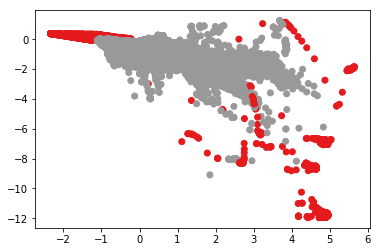

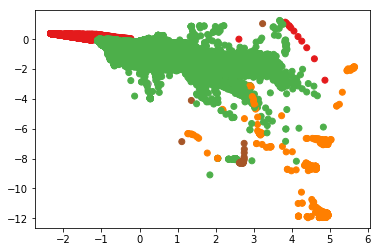

1034.853655576706


In [38]:
t0 = time()
viz_train_data = np.array(pca_train_df.rdd.map(lambda row: [*row['pca_features'], row['labels2_index'], row['labels5_index']]).collect())
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,2], cmap="Set1")
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,3], cmap="Set1")
plt.show()
print(time() - t0)

# 4- Modeling and Predictions with Random Forest

In [4]:
#fulldata
mydf = spark.read \
    .option("header", "false") \
    .option("inferSchema", "true") \
    .csv("hdfs:///user/hduser"+dataset_path+"full.data")

    
#corrected data (to be joined with full data for training purpose) ---> ###laster will use random split to do cross validation### 
mydf_1 = spark.read \
    .option("header", "false") \
    .option("inferSchema", "true") \
    .csv("hdfs:///user/hduser"+dataset_path+"corrected")

#join the mydf and mydf_1 into mydf
mydf = mydf.union(mydf_1)


#corrected data
mytest = spark.read \
    .option("header", "false") \
    .option("inferSchema", "true") \
    .csv("hdfs:///user/hduser"+dataset_path+"testdata.unlabeled")

### Preparing data for Random forest

1. three of features are stringtype --> change to vertor using pipelines methods, 1 pipeline per column

2. !!!! save these pipelines configuration unchanged to make sure we do the exactly same treatment for features in testdata.unlabeled!!!!

3. the final format of data should be 'libsvm'

In [5]:
categorical_columns = ['_c1','_c2', '_c3']

##=== build stages ======
stringindexer_stages = [StringIndexer(inputCol=c, outputCol='stringindexed_' + c) for c in categorical_columns]
onehotencoder_stages = [OneHotEncoder(inputCol='stringindexed_' + c, outputCol='onehotencoded_' + c) for c in categorical_columns]
all_stages = stringindexer_stages + onehotencoder_stages

## build pipeline model
pipeline = Pipeline(stages=all_stages)

## fit pipeline model
pipeline_mode = pipeline.fit(mydf)

## transform data
df_coded = pipeline_mode.transform(mydf)

## remove uncoded columns
df_coded = df_coded.drop('_c1').drop('_c3').drop('_c2').\
                    drop('stringindexed__c1').drop('stringindexed__c3').drop('stringindexed__c2')
    
# feature columns
feature_columns = df_coded.drop('_c41').columns

# build VectorAssembler instance
vectorassembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# transform data
df_features = vectorassembler.transform(df_coded)

#####  '_c41' is the target(label), which has many values ---> change those not equals 'normal.' into 'attack'. At the end only keeping two level: 'Normal' or 'Attack'

In [6]:
df_features = df_features.withColumn('_c41_corrected', sql.regexp_replace(col('_c41'), '^(?!normal).*$', 'attack')).drop('_c41')
df_features.select('_c41_corrected').distinct().show()

+--------------+
|_c41_corrected|
+--------------+
|        attack|
|       normal.|
+--------------+



##### Prepared data into 'libsvm' format for Random Forest

In [7]:
labelIndexer = StringIndexer(inputCol="_c41_corrected", outputCol="label").fit(df_features)
df_features = labelIndexer.transform(df_features).select(['label','features'])
df_features.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
|  1.0|(120,[1,2,8,19,20...|
+-----+--------------------+
only showing top 20 rows



## Predictive Model Training

In [8]:
t0 = time()
data = df_features

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 32 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=32).fit(data)

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = data.randomSplit([0.8, 0.2], seed = 10)

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees= 5, maxDepth = 24)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.    
predictions.select("predictedLabel", "label", "features").show(5)

rfModel = model.stages[2]
print(rfModel)  # summary only

#Cross Tab
final_results = predictions.select("predictedLabel", "label")
cross_tab_results = final_results.crosstab('label','predictedLabel', )
CrossTab = cross_tab_results.toPandas()
CrossTab = CrossTab.set_index('label_predictedLabel')[['1.0','0.0']]

#Overall Error and Recall Error
Recall_Error = CrossTab.values[1][0] / (CrossTab.values[1][0] + CrossTab.values[1][1])
Overall_Error = 1 - ((CrossTab.values[0][0] + CrossTab.values[1][1]) / CrossTab.sum().sum())


print(CrossTab)
print('The Recall error is ' + str(Recall_Error))
print('The Overall error is ' + str(Overall_Error))
print('Training the model takes ' + str((time() - t0)) + ' second')

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|(120,[0,1,2,6,7,1...|
|           0.0|  0.0|(120,[0,1,2,6,8,9...|
|           1.0|  0.0|(120,[0,1,2,8,9,1...|
|           1.0|  0.0|(120,[0,1,2,8,9,1...|
|           1.0|  0.0|(120,[0,1,2,19,20...|
+--------------+-----+--------------------+
only showing top 5 rows

RandomForestClassificationModel (uid=RandomForestClassifier_4cdf8b9f9e798b3702f4) with 5 trees
                         1.0     0.0
label_predictedLabel                
1.0                   206395     319
0.0                     1714  833148
The Recall error is 0.0020530339145870815
The Overall error is 0.0019518498890143121
Training the model takes 647.1396224498749 second


###  The Recall Error:
# 0.09%
###  The Overall Error:
# 0.2%
###  Training the model takes 54 seconds


## Parameter Tunning
### To make the most of the random forest we have also done a parameter tunning over Max_Depth, and we find out when Max_Depth = 24, the model gives the lowest recall error.

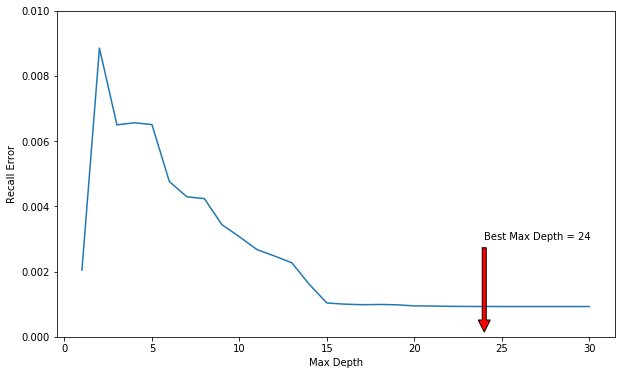

In [11]:
error_table = pd.read_csv('/home/hduser/error_table.csv')
error_table.max_depth.values

x = error_table.max_depth.values
y = error_table.error.values

fig, ax = plt.subplots()

fig.set_size_inches(10, 6)

ax.plot(x, y)
ax.set_xlabel('Max Depth')
ax.set_ylabel('Recall Error')
ax.annotate('Best Max Depth = 24', 
            xy=(24, 0), 
            xytext=(24, 0.003), 
            arrowprops = dict(facecolor='red', shrink=0.05))
ax.set_ylim(0,0.01)

plt.show()

## Prepare the test data for prediction: mytest

In [12]:
categorical_columns = ['_c1','_c2', '_c3']

## transform data                    ######!!!using the same pipelines as we use for the training set!!!######
df_coded = pipeline_mode.transform(mytest)

## remove uncoded columns
df_coded = df_coded.drop('_c1').drop('_c3').drop('_c2').\
                    drop('stringindexed__c1').drop('stringindexed__c3').drop('stringindexed__c2')
    
# feature columns
feature_columns = df_coded.columns

# build VectorAssembler instance
vectorassembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# transform data
df_features_test = vectorassembler.transform(df_coded)

# keep only 'features' columns for prediction
df_features_test = df_features_test.select('features')
df_features_test.show()

+--------------------+
|            features|
+--------------------+
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
|(120,[1,2,19,20,2...|
+--------------------+
only showing top 20 rows



## Predicted Results

In [13]:
t0 = time()
prediction_1 = model.transform(df_features_test)
prediction_1.select('prediction').show()

print('Predicting each record takes ' + str((time() - t0) / prediction_1.count()) + ' second')

+----------+
|prediction|
+----------+
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
|       1.0|
+----------+
only showing top 20 rows

Predicting each record takes 1.638341665726381e-07 second


# Final Comments and Result:

#### Predicting each record takes 4.3026340575458964e-08 second (Based on IE Cluster)

# Recommendations

1- It is recommended to use 'pickle' library of python in order to save a trained model and run it on bigger clusters in real time

2- Since the model efficiency has been verified and tested thoroughly, it is receommended to use Spark Streaming for analysis and filtering out attacks in real time data.

3- Do not forget to run the following statement, this notebook will be automatically destroyed. ;)

In [26]:
sc.stop()

#####                       ---------------------------------A project of team O2-6------------------------------------------------